In [1]:
import os
from pprint import pprint
import sys
import json

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy import stats
import pickle

project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import viz, constants
from sleeprnn.helpers import reader, plotter, misc, performer
from sleeprnn.detection import metrics, det_utils, ensemble
from figs_thesis import fig_utils
from baselines_scripts.butils import get_partitions
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.data import utils

RESULTS_PATH = os.path.join(project_root, 'results')
BASELINES_PATH = os.path.join(project_root, 'resources', 'comparison_data', 'baselines_2021')

%matplotlib inline
viz.notebook_full_width()

# Mismo criterio de anotación (test subjects in-dataset)

In [2]:
models = [constants.V2_TIME, constants.V2_CWT1D]
print_model_names = {
    constants.V2_TIME: 'REDv2-Time',
    constants.V2_CWT1D: 'REDv2-CWT',
}
print_dataset_names = {
    (constants.MASS_SS_NAME, 1): "MASS-SS2-E1SS",
    (constants.MASS_SS_NAME, 2): "MASS-SS2-E2SS",
    (constants.MODA_SS_NAME, 1): "MASS-MODA",
    (constants.INTA_SS_NAME, 1): "INTA-UCH",
}
eval_configs = [
    dict(dataset_name=constants.MASS_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MASS_SS_NAME, expert=2, strategy='5cv', seeds=3),
    dict(dataset_name=constants.MODA_SS_NAME, expert=1, strategy='5cv', seeds=3),
    dict(dataset_name=constants.INTA_SS_NAME, expert=1, strategy='5cv', seeds=3),
]

### PR by-subject, cheating

```
MASS-SS2-E1SS REDv2-Time (umbral original) F1-score 80.8670 ± 3.5689
MASS-SS2-E1SS REDv2-CWT (umbral original) F1-score 80.9078 ± 3.3566

MASS-SS2-E1SS REDv2-Time (umbral oráculo) F1-score 82.7517 ± 3.0363
MASS-SS2-E1SS REDv2-CWT (umbral oráculo) F1-score 82.8609 ± 2.8293



MASS-SS2-E2SS REDv2-Time (umbral original) F1-score 86.1270 ± 3.3854
MASS-SS2-E2SS REDv2-CWT (umbral original) F1-score 86.1067 ± 3.4184

MASS-SS2-E2SS REDv2-Time (umbral oráculo) F1-score 87.0420 ± 2.9517
MASS-SS2-E2SS REDv2-CWT (umbral oráculo) F1-score 87.1587 ± 2.8882



MASS-MODA REDv2-Time (umbral original) F1-score 78.5749 ± 7.0126
MASS-MODA REDv2-CWT (umbral original) F1-score 78.4800 ± 6.9449

MASS-MODA REDv2-Time (umbral oráculo) F1-score 80.9279 ± 5.8059
MASS-MODA REDv2-CWT (umbral oráculo) F1-score 80.8579 ± 6.0169



INTA-UCH REDv2-Time (umbral original) F1-score 83.8991 ± 4.7945
INTA-UCH REDv2-CWT (umbral original) F1-score 83.5663 ± 5.2646

INTA-UCH REDv2-Time (umbral oráculo) F1-score 84.4179 ± 4.3854
INTA-UCH REDv2-CWT (umbral oráculo) F1-score 84.0723 ± 4.6876
```

In [4]:
metrics_list = []
for config in eval_configs:
    print("\nLoading", config)
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    pred_dict = {}
    for model_version in models:
        tmp_dict = fig_utils.get_red_predictions(model_version, config["strategy"], dataset, config["expert"], verbose=False)
        # Retrieve only predictions, same format as baselines
        pred_dict[model_version] = {}
        for k in tmp_dict.keys():
            fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
            fold_predictions = tmp_dict[k][constants.TEST_SUBSET].get_stamps()
            pred_dict[model_version][k] = {s: pred for s, pred in zip(fold_subjects, fold_predictions)}
    
    # Measure performance by subject
    _, _, test_ids_list = get_partitions(dataset, config["strategy"], config["seeds"])
    n_folds = len(test_ids_list)
    table = {'Detector': [], 'F1-score': [], 'Recall': [], 'Precision': [], 'mIoU': [], 'Subject': [], 'Fold': []}
    
    # In MODA, only some subjects are used (N=28)
    if config["dataset_name"] == constants.MODA_SS_NAME:
        valid_subjects = [
            sub_id for sub_id in dataset.all_ids
            if (dataset.data[sub_id]['n_blocks'] == 10)
               and (sub_id not in ['01-01-0012', '01-01-0022'])
        ]
        print("moda, using n=", len(valid_subjects))
    else:
        valid_subjects = dataset.all_ids
    
    for model_name in models:
        for k in range(n_folds):
            subject_ids = test_ids_list[k]
            subject_ids = [s for s in subject_ids if s in valid_subjects]
            feed_d = FeederDataset(dataset, subject_ids, constants.N2_RECORD, which_expert=config["expert"])
            events_list = feed_d.get_stamps()
            detections_list = [pred_dict[model_name][k][subject_id] for subject_id in subject_ids]
            performance = fig_utils.compute_subject_performance(events_list, detections_list)
            for i, subject_id in enumerate(subject_ids):
                if subject_id in valid_subjects:
                    table['Detector'].append(model_name)
                    table['F1-score'].append(performance['F1-score'][i])
                    table['Recall'].append(performance['Recall'][i])
                    table['Precision'].append(performance['Precision'][i])
                    table['mIoU'].append(performance['mIoU'][i])
                    table['Subject'].append(subject_id)
                    table['Fold'].append(k)
    table = pd.DataFrame.from_dict(table)
    metrics_list.append(table)
print("Done.")


Loading {'dataset_name': 'mass_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}

Loading {'dataset_name': 'mass_ss', 'expert': 2, 'strategy': '5cv', 'seeds': 3}

Loading {'dataset_name': 'moda_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}
moda, using n= 28

Loading {'dataset_name': 'inta_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}
Done.


In [16]:
# Cheating performance
cheat_thr_df = pd.read_csv('cheating_thresholds.csv')

def get_cheat_thr(dataset_str, model_version, fold_id, subject_id):
    subject_id = str(subject_id)
    row = cheat_thr_df[
        (cheat_thr_df.dataset == dataset_str) 
        & (cheat_thr_df.model == model_version)
        & (cheat_thr_df.fold == fold_id)
        & (cheat_thr_df.subject == subject_id)
    ]
    this_cheat_thr = row.cheat_thr.values.item()
    return this_cheat_thr

In [18]:
metrics_cheat_list = []
for config in eval_configs:
    print("\nLoading", config)
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    dataset_str = print_dataset_names[(config["dataset_name"], config["expert"])]
    # In MODA, only some subjects are used (N=28)
    if config["dataset_name"] == constants.MODA_SS_NAME:
        valid_subjects = [
            sub_id for sub_id in dataset.all_ids
            if (dataset.data[sub_id]['n_blocks'] == 10)
               and (sub_id not in ['01-01-0012', '01-01-0022'])
        ]
        print("moda, using n=", len(valid_subjects))
    else:
        valid_subjects = dataset.all_ids
    
    pred_dict = {}
    for model_version in models:
        tmp_dict = fig_utils.get_red_predictions(model_version, config["strategy"], dataset, config["expert"], verbose=False)
        # Retrieve only predictions, same format as baselines
        pred_dict[model_version] = {}
        for k in tmp_dict.keys():
            fold_subjects = tmp_dict[k][constants.TEST_SUBSET].all_ids
            pred_dict[model_version][k] = {}
            for subject_id in fold_subjects:
                if subject_id not in valid_subjects:
                    continue
                subject_cheat_thr = get_cheat_thr(dataset_str, model_version, k, subject_id)
                tmp_dict[k][constants.TEST_SUBSET].set_probability_threshold(subject_cheat_thr)
                subject_predictions = tmp_dict[k][constants.TEST_SUBSET].get_subject_stamps(subject_id)
                pred_dict[model_version][k][subject_id] = subject_predictions
    
    # Measure performance by subject
    _, _, test_ids_list = get_partitions(dataset, config["strategy"], config["seeds"])
    n_folds = len(test_ids_list)
    table = {'Detector': [], 'F1-score': [], 'Recall': [], 'Precision': [], 'mIoU': [], 'Subject': [], 'Fold': []}
    
    for model_name in models:
        for k in range(n_folds):
            subject_ids = test_ids_list[k]
            subject_ids = [s for s in subject_ids if s in valid_subjects]
            feed_d = FeederDataset(dataset, subject_ids, constants.N2_RECORD, which_expert=config["expert"])
            events_list = feed_d.get_stamps()
            detections_list = [pred_dict[model_name][k][subject_id] for subject_id in subject_ids]
            performance = fig_utils.compute_subject_performance(events_list, detections_list)
            for i, subject_id in enumerate(subject_ids):
                if subject_id in valid_subjects:
                    table['Detector'].append(model_name)
                    table['F1-score'].append(performance['F1-score'][i])
                    table['Recall'].append(performance['Recall'][i])
                    table['Precision'].append(performance['Precision'][i])
                    table['mIoU'].append(performance['mIoU'][i])
                    table['Subject'].append(subject_id)
                    table['Fold'].append(k)
    table = pd.DataFrame.from_dict(table)
    metrics_cheat_list.append(table)
print("Done.")


Loading {'dataset_name': 'mass_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}

Loading {'dataset_name': 'mass_ss', 'expert': 2, 'strategy': '5cv', 'seeds': 3}

Loading {'dataset_name': 'moda_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}
moda, using n= 28

Loading {'dataset_name': 'inta_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}
Done.


MASS-SS2-E1SS REDv2-Time (umbral original) F1-score 80.8670 ± 3.5689
MASS-SS2-E1SS REDv2-CWT (umbral original) F1-score 80.9078 ± 3.3566
MASS-SS2-E1SS REDv2-Time (umbral oráculo) F1-score 82.7517 ± 3.0363
MASS-SS2-E1SS REDv2-CWT (umbral oráculo) F1-score 82.8609 ± 2.8293
MASS-SS2-E2SS REDv2-Time (umbral original) F1-score 86.1270 ± 3.3854
MASS-SS2-E2SS REDv2-CWT (umbral original) F1-score 86.1067 ± 3.4184
MASS-SS2-E2SS REDv2-Time (umbral oráculo) F1-score 87.0420 ± 2.9517
MASS-SS2-E2SS REDv2-CWT (umbral oráculo) F1-score 87.1587 ± 2.8882
MASS-MODA REDv2-Time (umbral original) F1-score 78.5749 ± 7.0126
MASS-MODA REDv2-CWT (umbral original) F1-score 78.4800 ± 6.9449
MASS-MODA REDv2-Time (umbral oráculo) F1-score 80.9279 ± 5.8059
MASS-MODA REDv2-CWT (umbral oráculo) F1-score 80.8579 ± 6.0169
INTA-UCH REDv2-Time (umbral original) F1-score 83.8991 ± 4.7945
INTA-UCH REDv2-CWT (umbral original) F1-score 83.5663 ± 5.2646
INTA-UCH REDv2-Time (umbral oráculo) F1-score 84.4179 ± 4.3854
INTA-UCH R

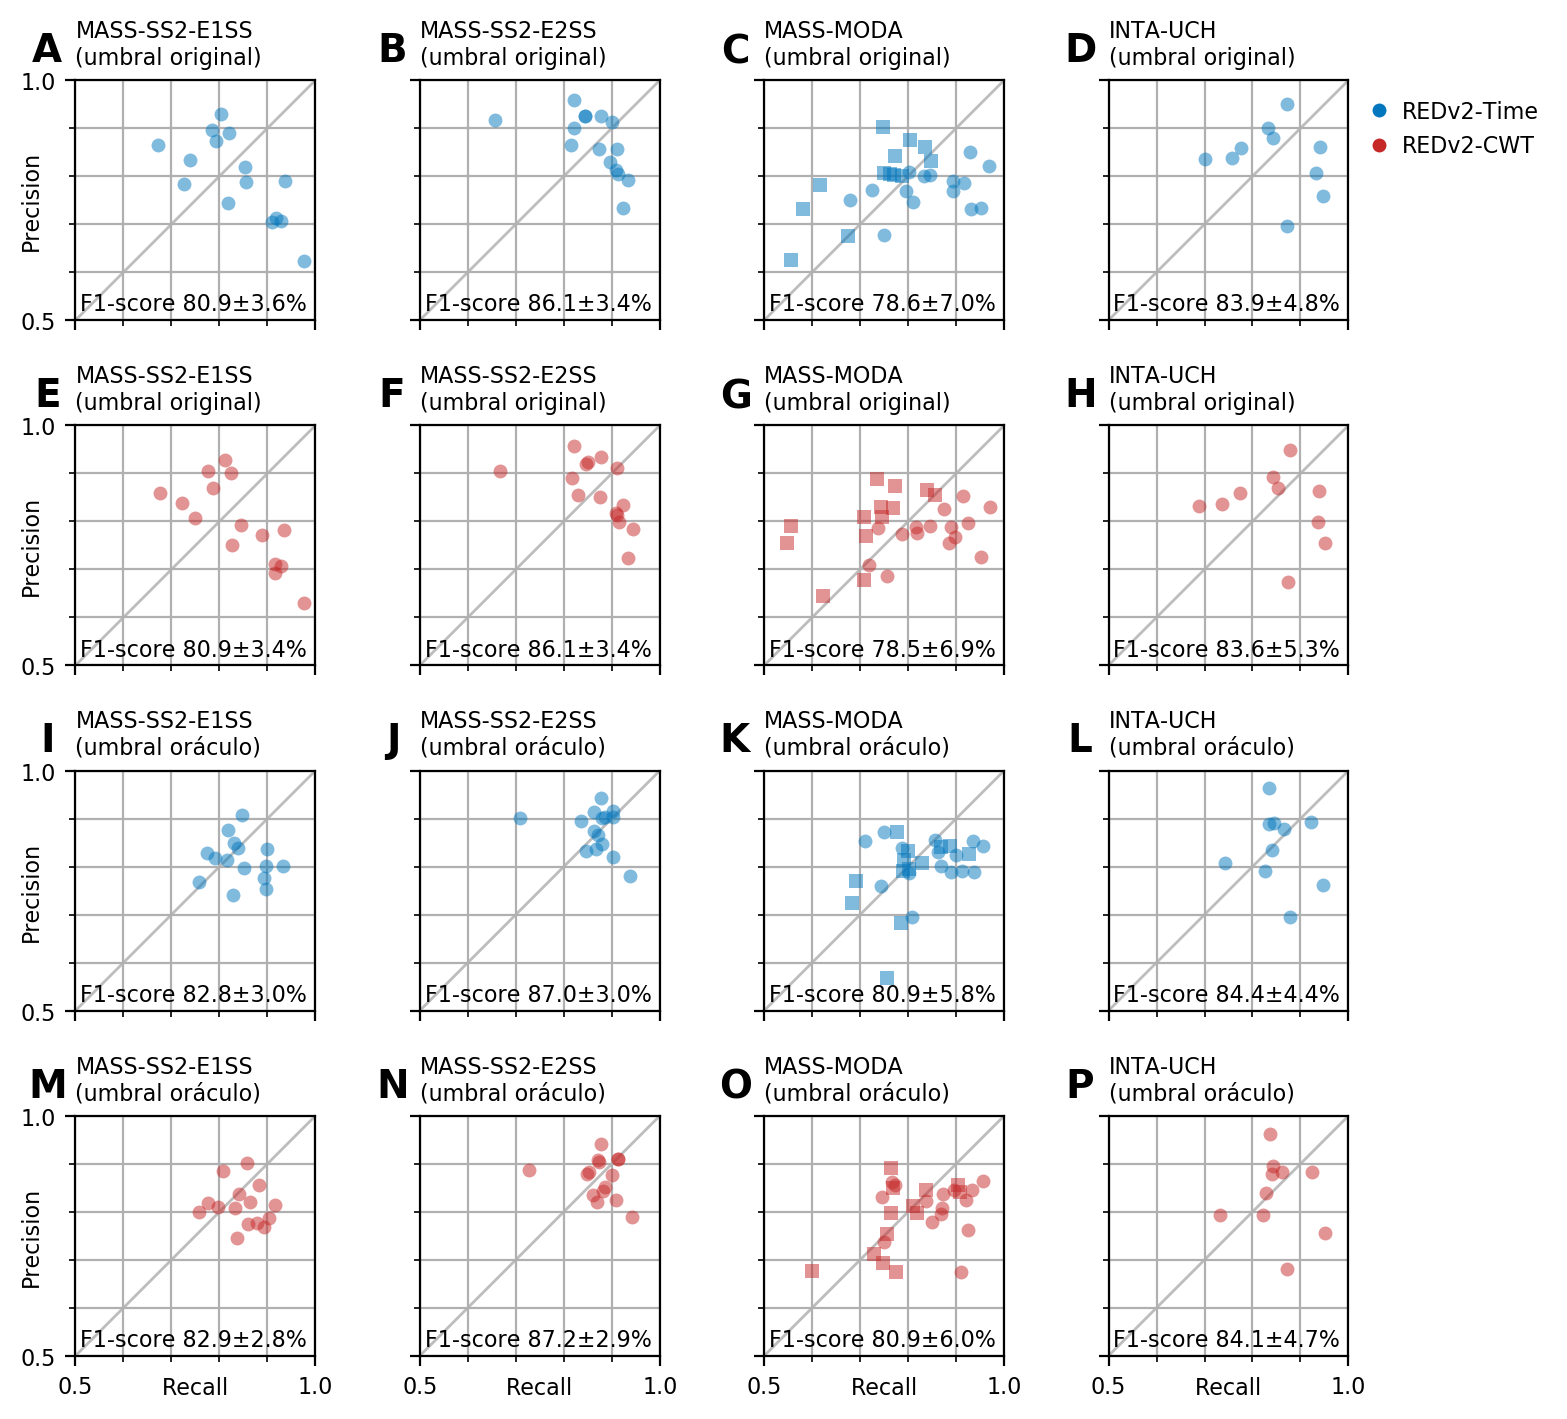

In [91]:
# PR by-subject
save_figure = True

colors = {constants.V2_TIME: viz.PALETTE['blue'], constants.V2_CWT1D: viz.PALETTE['red']}
marker_size = 5
marker_alpha = 0.5
letters = [
    ['A', 'B', 'C', 'D'], 
    ['E', 'F', 'G', 'H'],
    ['I', 'J', 'K', 'L'], 
    ['M', 'N', 'O', 'P'],
]

fig, axes = plt.subplots(4, 4, figsize=(8, 7.2), dpi=200, sharex=True, sharey=True)

for i_config, config in enumerate(eval_configs):
    for i_cheat, m_list in enumerate([metrics_list, metrics_cheat_list]):
        for j, model_version in enumerate(models):
            row_value = j + i_cheat * 2
            col_value = i_config
            ax = axes[row_value, col_value]
            table = m_list[i_config]
            
            model_str = print_model_names[model_version]
            dataset_str = print_dataset_names[(config['dataset_name'], config['expert'])]
            
            # Form by-subject metrics 
            table_subject = table.drop(columns=["Fold"]).groupby(by=["Detector", "Subject"]).mean().reset_index()  # subject avg

            table_model = table_subject[table_subject['Detector'] == model_version]
            subjects = table_model['Subject'].values
            recalls = table_model['Recall'].values
            precisions = table_model['Precision'].values
            
            if config['dataset_name'] == constants.MODA_SS_NAME:
                moda = reader.load_dataset(config["dataset_name"], verbose=False)
                phases = [moda.data[sub_id]['phase'] for sub_id in subjects]
                del moda
            else:
                phases = [1 for sub_id in subjects]

            # Draw
            marker_by_phase = {1: 'o', 2: 's'}
            for r, p, ph in zip(recalls, precisions, phases):
                ax.plot(
                    r, p, color=colors[model_version], linestyle='None', alpha=marker_alpha,
                    markeredgewidth=0.0, marker=marker_by_phase[ph], markersize=marker_size)
            ax.plot(
                [], [], color=colors[constants.V2_TIME], linestyle='None', alpha=1.0,
                markeredgewidth=0.0, marker='o', markersize=marker_size, label=print_model_names[constants.V2_TIME])
            ax.plot(
                [], [], color=colors[constants.V2_CWT1D], linestyle='None', alpha=1.0,
                markeredgewidth=0.0, marker='o', markersize=marker_size, label=print_model_names[constants.V2_CWT1D])
            
            cheat_str = '(umbral original)' if i_cheat == 0 else '(umbral oráculo)'
            
            f1_scores = 2 * recalls * precisions / (recalls + precisions)
            f1_mean = np.mean(f1_scores)
            f1_std = np.std(f1_scores)
            f1_str = '%1.1f\u00B1%1.1f' % (100 * f1_mean, 100 * f1_std)
            
            f1_str_to_plots = 'F1-score %1.4f \u00B1 %1.4f' % (100 * f1_mean, 100 * f1_std)
            print(dataset_str, model_str, cheat_str, f1_str_to_plots)
            
            
            ax.set_title('%s\n%s' % (dataset_str, cheat_str), fontsize=8, loc="left")
            
            ax.text(x=0.51, y=0.51, fontsize=8, s='F1-score %s%%' % f1_str, ha='left', va='bottom')
            
            #ax.set_title('%s en %s' % (model_str, dataset_str), fontsize=8, loc="left")

            if False:
                subjects = table_model['Subject'].values
                print("\n", dataset_str, model_str, cheat_str)
                sorted_locs = np.argsort(precisions)
                for loc in sorted_locs:
                    this_rec = recalls[loc]
                    this_prec = precisions[loc]
                    this_subject = subjects[loc]
                    if this_prec < 0.71 or this_rec < 0.71:
                        if config['dataset_name'] == constants.MODA_SS_NAME:
                            this_phase = phases[loc]
                        else:
                            this_phase = -1
                        print("Subject %s (%d), Recall %1.1f, Precision %1.1f" % (this_subject, this_phase, this_rec * 100, this_prec * 100))

            ax.text(
                x=-0.12, y=1.08, fontsize=14, s=r"$\bf{%s}$" % letters[row_value][col_value],
                ha="center", transform=ax.transAxes)

        
for ax in axes.flatten():
    plotter.format_precision_recall_plot_simple(
        ax, axis_range=(0.5, 1.0), 
        show_quadrants=False, show_grid=True, 
        axis_markers=[0.5, 1], minor_axis_markers=np.arange(0.5, 1 + 0.001, 0.1))
    ax.tick_params(labelsize=8)
    # Get labels closer to axis
    ax.xaxis.labelpad = -8
    ax.yaxis.labelpad = -8

for ax in axes[:, 0]:
    ax.set_ylabel("Precision", fontsize=8)
for ax in axes[-1, :]:
    ax.set_xlabel("Recall", fontsize=8)
    

axes[0, -1].legend(loc='upper left', bbox_to_anchor=(0.95, 1), fontsize=8, frameon=False, handletextpad=0.05)
    
    
plt.tight_layout()

if save_figure:
    # Save figure
    fname_prefix = "result_transfer_indata_cheat_pr"
    plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.4)

plt.show()

### Outliers

In [100]:
outliers_dataset = {
    (constants.MASS_SS_NAME, 1): [14],
    (constants.MASS_SS_NAME, 2): [6, 18],
    (constants.MODA_SS_NAME, 1): [
        '01-01-0021', 
        # '01-01-0016', 
        # '01-05-0010', 
        '01-01-0013', 
        # '01-05-0004', 
        '01-01-0017'
    ],
    (constants.INTA_SS_NAME, 1): [3, 10],
}

In [93]:
# outlier subjects' spectrum in N2
freq_axis = None
spectrums_list = []
for config in eval_configs:
    print("\nLoading", config)
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    dataset_str = print_dataset_names[(config["dataset_name"], config["expert"])]
    
    # In MODA, only some subjects are used (N=28)
    if config["dataset_name"] == constants.MODA_SS_NAME:
        valid_subjects = [
            sub_id for sub_id in dataset.all_ids
            if (dataset.data[sub_id]['n_blocks'] == 10)
               and (sub_id not in ['01-01-0012', '01-01-0022'])
        ]
        print("moda, using n=", len(valid_subjects))
    else:
        valid_subjects = dataset.all_ids
    
    spectrums = {}
    for subject_id in valid_subjects:
        signal = dataset.get_subject_signal(subject_id, normalize_clip=False, which_expert=config["expert"])
        n2_pages = dataset.get_subject_pages(subject_id, pages_subset='n2')
        signal_valid = signal.reshape(-1, dataset.page_size)[n2_pages].flatten()
        freq_axis, amp_axis = utils.power_spectrum_by_sliding_window(signal_valid, dataset.fs)
        spectrums[subject_id] = amp_axis
    spectrums_list.append(spectrums)
print("Done.")


Loading {'dataset_name': 'mass_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}

Loading {'dataset_name': 'mass_ss', 'expert': 2, 'strategy': '5cv', 'seeds': 3}

Loading {'dataset_name': 'moda_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}
moda, using n= 28

Loading {'dataset_name': 'inta_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}
Done.


In [108]:
def reduce_data_by_band(f, y, f_min=0, f_max=100):
    locs = np.where((f >= f_min) & (f <= f_max))[0]
    f = f[locs]
    y = y[locs]
    return f, y


def get_original_id(dataset_name, custom_id):
    
    NAMES = [
        'ADGU',
        'ALUR',
        'BECA',
        'BRCA',
        'BRLO',
        'BTOL',
        'CAPO',
        'CRCA',
        'ESCI',
        'TAGO'
    ]
    
    if dataset_name == constants.MODA_SS_NAME:
        return custom_id
    elif dataset_name == constants.MASS_SS_NAME:
        return '01-02-%04d' % custom_id
    else:
        return NAMES[custom_id-1]

Subject 14, Dataset MASS-SS2-E1SS, Events 706, Density 2.90
Subject 6, Dataset MASS-SS2-E2SS, Events 822, Density 3.65
Subject 18, Dataset MASS-SS2-E2SS, Events 1642, Density 6.70
moda, using n= 28
Subject 01-01-0021, Dataset MASS-MODA, Events 45, Density 2.25
Subject 01-01-0013, Dataset MASS-MODA, Events 31, Density 1.55
Subject 01-01-0017, Dataset MASS-MODA, Events 27, Density 1.35
Subject 3, Dataset INTA-UCH, Events 633, Density 3.26
Subject 10, Dataset INTA-UCH, Events 1041, Density 5.91


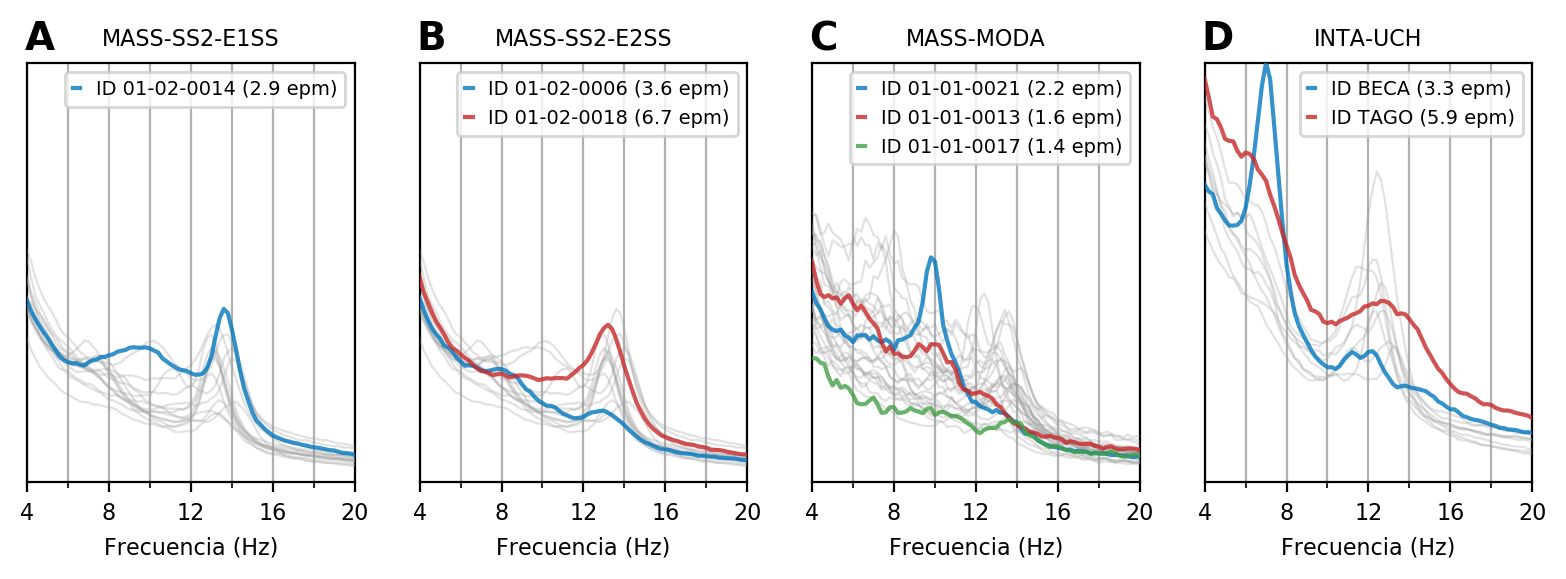

In [124]:
save_figure = True

f_min = 4
f_max = 20
color_series = ['blue', 'red', 'green']
letters = ['A', 'B', 'C', 'D']

fig, axes = plt.subplots(1, 4, figsize=(8, 3), dpi=200, sharey=True)
max_y = 0
for i_config, config in enumerate(eval_configs):
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    dataset_str = print_dataset_names[(config["dataset_name"], config["expert"])]
    
    # In MODA, only some subjects are used (N=28)
    if config["dataset_name"] == constants.MODA_SS_NAME:
        valid_subjects = [
            sub_id for sub_id in dataset.all_ids
            if (dataset.data[sub_id]['n_blocks'] == 10)
               and (sub_id not in ['01-01-0012', '01-01-0022'])
        ]
        print("moda, using n=", len(valid_subjects))
    else:
        valid_subjects = dataset.all_ids
        
    spectrums = spectrums_list[i_config]
    this_outliers = outliers_dataset[(config["dataset_name"], config["expert"])]
    
    ax = axes[i_config]
    highlight_count = 0
    for subject_id in valid_subjects:
        s = spectrums[subject_id]
        f, s = reduce_data_by_band(freq_axis, s, f_min=f_min, f_max=f_max)
        max_y = max(max_y, s.max())
        if subject_id not in this_outliers:
            ax.plot(f, s, linewidth=0.8, alpha=0.3, color=viz.GREY_COLORS[5], zorder=10)
    
    for i_high, subject_id in enumerate(this_outliers):
        
        # find number of annotations
        events = dataset.get_subject_stamps(subject_id, which_expert=config['expert'], pages_subset='n2')
        n2_pages = dataset.get_subject_pages(subject_id, pages_subset='n2')
        subject_event_count = events.shape[0]
        subject_density = subject_event_count / (n2_pages.size * dataset.page_duration / 60)
        print("Subject %s, Dataset %s, Events %d, Density %1.2f" % (subject_id, dataset_str, subject_event_count, subject_density))
        
        s = spectrums[subject_id]
        f, s = reduce_data_by_band(freq_axis, s, f_min=f_min, f_max=f_max)
        
        # Here change ids to original (needed for MASS (01-02-etc) and INTA (BECA, TAGO etc))
        subject_id_original = get_original_id(config["dataset_name"], subject_id)
        
        ax.plot(
            f, s, linewidth=1.5, alpha=0.8, zorder=20, color=viz.PALETTE[color_series[i_high]], 
            label="ID %s (%1.1f epm)" % (subject_id_original, subject_density))

    ax.legend(loc="upper right", fontsize=7, handlelength=0.4)
    
    ax.tick_params(labelsize=8)
    ax.set_yticks([])
    ax.set_xlabel("Frecuencia (Hz)", fontsize=8)
    
    title_str = '%s' % dataset_str
    ax.set_title(title_str, fontsize=8, loc="center")
    
    ax.text(
        x=-0.01, y=1.03, fontsize=14, s=r"$\bf{%s}$" % letters[i_config],
        ha="left", transform=ax.transAxes)
    
for ax in axes.flatten():
    ax.set_ylim([0, max_y])
    ax.set_xticks(np.arange(4, 20 + 0.001, 4))
    ax.set_xticks(np.arange(4, 20 + 0.001, 2), minor=True)
    ax.set_xlim([4, 20])
    ax.grid(axis="x", which="minor")

plt.tight_layout()

if save_figure:
    # Save figure
    fname_prefix = "result_transfer_indata_spectra"
    plt.savefig("%s.pdf" % fname_prefix, bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.png" % fname_prefix, bbox_inches="tight", pad_inches=0.4)
    plt.savefig("%s.svg" % fname_prefix, bbox_inches="tight", pad_inches=0.4)

plt.show()

### Fracciones de sujetos válidas
Con al menos un evento, también buscar sujeto más corto. En evernote:

Preparar evolución F1-score: Estudiar si "rho" es % de páginas N2 (relativo a cada sujeto) o número de páginas N2 /minutos (absoluto). Ojalá minutos, para ello hay que estudiar los largos de los sujetos de las bases de interés y cuánto es el mínimo número de minutos para tener algún evento disponible (sobre todo en MASS-SS2-E1SS). Si es %, llegar solo hasta 50%, si es absoluto entonces seria llegar al 50% del sujeto más corto en cada dataset de forma independiente. 

In [3]:
# find shortest duration 
for config in eval_configs:
    print("\nLoading", config)
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    dataset_str = print_dataset_names[(config["dataset_name"], config["expert"])]
    
    # In MODA, only some subjects are used (N=28)
    if config["dataset_name"] == constants.MODA_SS_NAME:
        valid_subjects = [
            sub_id for sub_id in dataset.all_ids
            if (dataset.data[sub_id]['n_blocks'] == 10)
               and (sub_id not in ['01-01-0012', '01-01-0022'])
        ]
        print("moda, using n=", len(valid_subjects))
    else:
        valid_subjects = dataset.all_ids
    
    min_pages = 1e5
    for subject_id in valid_subjects:
        this_pages = dataset.get_subject_pages(subject_id, pages_subset='n2')
        this_data_available = this_pages.size
        min_pages = min(min_pages, this_data_available)
    print("%s: shortest subject has %d N2 pages" % (dataset_str, min_pages))


Loading {'dataset_name': 'mass_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}
MASS-SS2-E1SS: shortest subject has 496 N2 pages

Loading {'dataset_name': 'mass_ss', 'expert': 2, 'strategy': '5cv', 'seeds': 3}
MASS-SS2-E2SS: shortest subject has 496 N2 pages

Loading {'dataset_name': 'moda_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}
moda, using n= 28
MASS-MODA: shortest subject has 60 N2 pages

Loading {'dataset_name': 'inta_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}
INTA-UCH: shortest subject has 457 N2 pages



Loading {'dataset_name': 'mass_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}
MASS-SS2-E1SS: shortest subject has 496 N2 pages
max number of N2 pages to try: 248 (82.67 minutes)

Loading {'dataset_name': 'mass_ss', 'expert': 2, 'strategy': '5cv', 'seeds': 3}
MASS-SS2-E2SS: shortest subject has 496 N2 pages
max number of N2 pages to try: 248 (82.67 minutes)

Loading {'dataset_name': 'moda_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}
moda, using n= 28
MASS-MODA: shortest subject has 60 N2 pages
max number of N2 pages to try: 30 (10.00 minutes)

Loading {'dataset_name': 'inta_ss', 'expert': 1, 'strategy': '5cv', 'seeds': 3}
INTA-UCH: shortest subject has 457 N2 pages
max number of N2 pages to try: 228 (76.00 minutes)


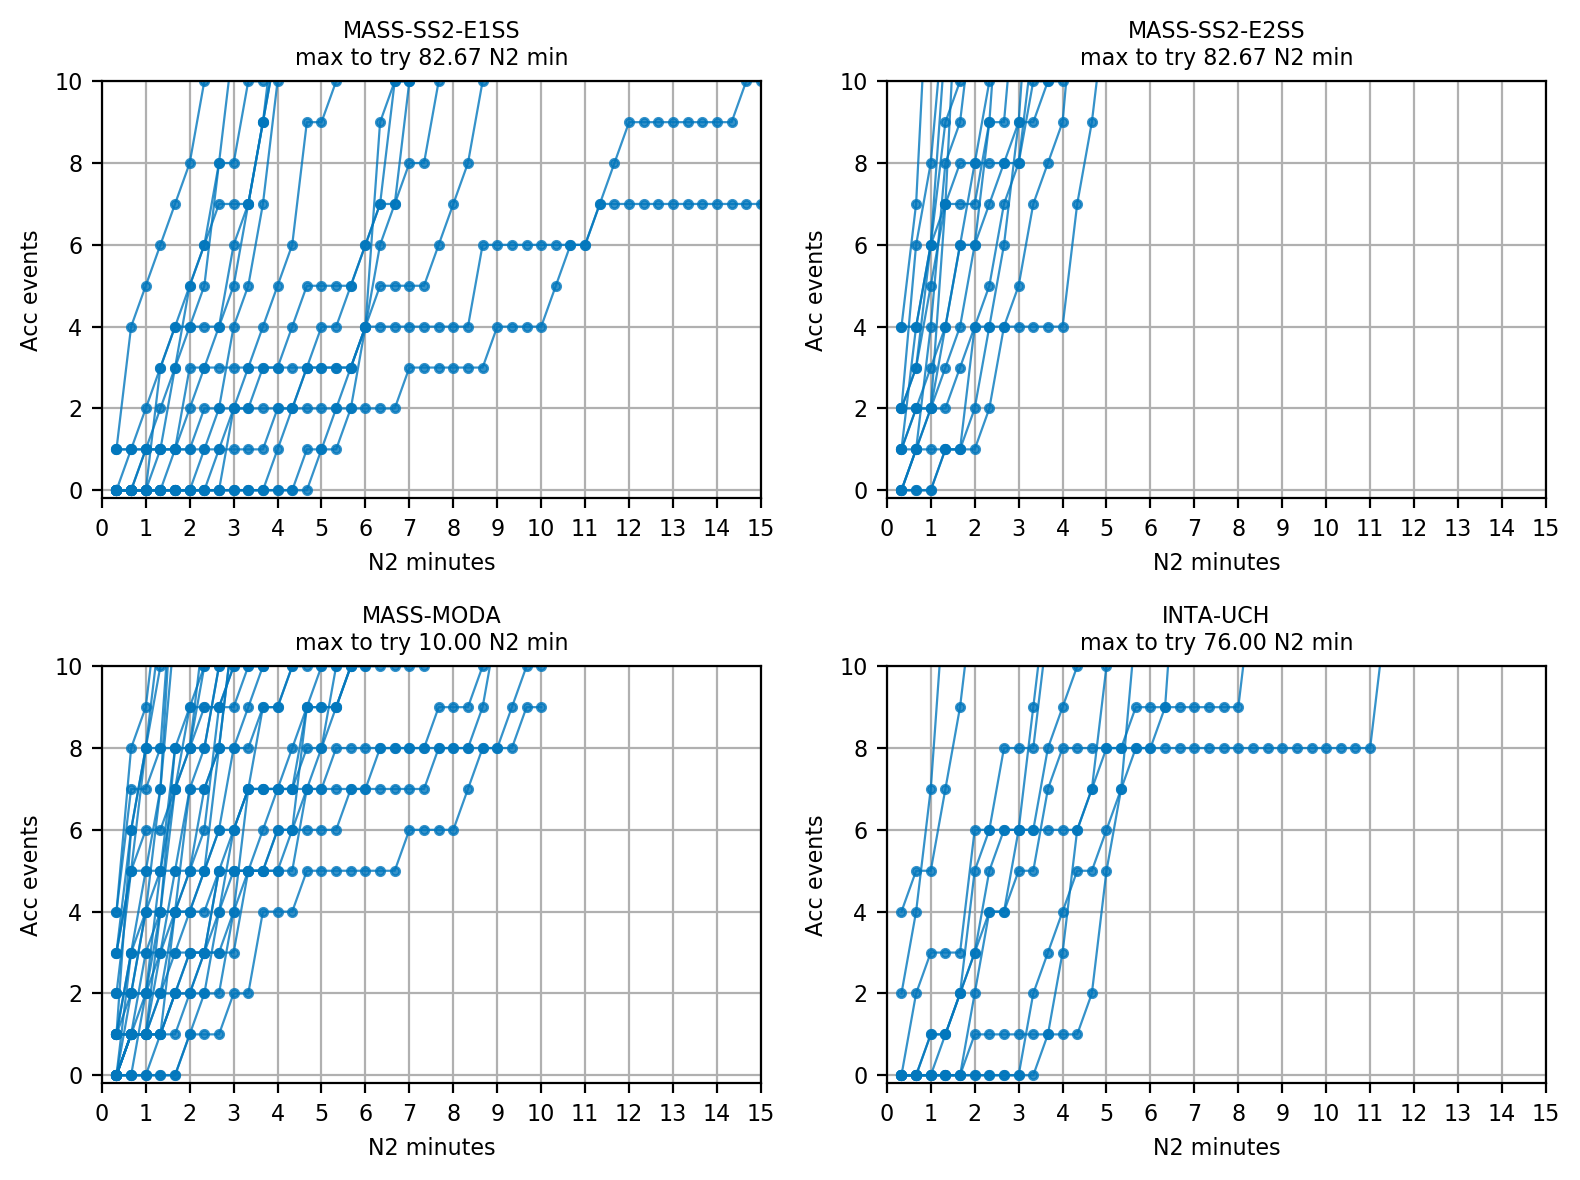

In [30]:
# find cumulative distribution of events
fig, axes = plt.subplots(2,2, figsize=(8, 6), dpi=200)
axes = axes.flatten()
for i_config, config in enumerate(eval_configs):
    print("\nLoading", config)
    dataset = reader.load_dataset(config["dataset_name"], verbose=False)
    dataset_str = print_dataset_names[(config["dataset_name"], config["expert"])]
    
    # In MODA, only some subjects are used (N=28)
    if config["dataset_name"] == constants.MODA_SS_NAME:
        valid_subjects = [
            sub_id for sub_id in dataset.all_ids
            if (dataset.data[sub_id]['n_blocks'] == 10)
               and (sub_id not in ['01-01-0012', '01-01-0022'])
        ]
        print("moda, using n=", len(valid_subjects))
    else:
        valid_subjects = dataset.all_ids
    
    min_pages = 1e5
    for subject_id in valid_subjects:
        this_pages = dataset.get_subject_pages(subject_id, pages_subset='n2')
        this_data_available = this_pages.size
        min_pages = min(min_pages, this_data_available)
    print("%s: shortest subject has %d N2 pages" % (dataset_str, min_pages))
    
    maximum_to_try = min_pages // 2
    
    print("max number of N2 pages to try: %d (%1.2f minutes)" % (maximum_to_try, maximum_to_try * dataset.page_duration / 60))
    
    p_possible = np.arange(1, maximum_to_try + 1)
    all_cumulatives = []
    for subject_id in valid_subjects:
        this_events = dataset.get_subject_stamps(subject_id, which_expert=config['expert'], pages_subset='n2')
        this_pages = dataset.get_subject_pages(subject_id, pages_subset='n2')
        subject_cumulative_events = []
        for p in p_possible:
            subset_pages = this_pages[:p]
            subset_events = utils.extract_pages_for_stamps(this_events, subset_pages, dataset.page_size)
            n_events = subset_events.shape[0]
            subject_cumulative_events.append(n_events)
        subject_cumulative_events = np.array(subject_cumulative_events)
        all_cumulatives.append(subject_cumulative_events)
    
    # now plot
    p_possible_in_min = p_possible * dataset.page_duration / 60
    ax = axes[i_config]
    for subject_cumulative_events in all_cumulatives:
        ax.plot(p_possible_in_min, subject_cumulative_events, linewidth=0.8, marker='o', markersize=3, alpha=0.8, color=viz.PALETTE['blue'])
    ax.set_ylim([-0.2, 10])
    ax.set_xlim([0, 15])
    ax.set_xticks(np.arange(0, 15.5, 1))
    ax.set_xlabel("N2 minutes", fontsize=8)
    ax.set_ylabel("Acc events", fontsize=8)
    ax.set_title("%s\nmax to try %1.2f N2 min" % (dataset_str, maximum_to_try * dataset.page_duration / 60), fontsize=8)
    ax.tick_params(labelsize=8)
    ax.grid()
plt.tight_layout()

plt.savefig("acc_events_by_n2_minutes_per_subject.pdf")

plt.show()